In [2]:
import re
import datetime
from datetime import date
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import numpy as np
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 100)

In [2]:
dfa = pd.read_csv('data.csv', thousands=',')
xd = pd.read_csv('pag1.csv', thousands=',')

dfa.set_index(dfa['No.'], inplace=True)
dfa.drop(dfa.columns[0:2], axis = 1, inplace = True)
dfa = xd.append(dfa)
dfa.drop_duplicates(keep='first', inplace=True) ###Need to check which are being dropped
dfa = dfa.astype('str').replace({'-':None})

#Market Cap to scale of billions
d = {'M': '*0.001', 'B': ''}
dfa['Market Cap'] = dfa['Market Cap'].fillna(0)
dfa['Market Cap'] = dfa['Market Cap'].astype('str').replace(d, regex=True, method=None).map(pd.eval)
#Recommendations to numbers
dfa["Recom"] = pd.to_numeric(dfa["Recom"], downcast="float")
#Volume to numbers
dfa["Volume"] = dfa["Volume"].astype('int')
dfa["Price"] = dfa["Price"].astype('float')
dfa["RSI"] = dfa["RSI"].astype('float')
#Percentages to floats
cols = ['EPS this Y', 'EPS past 5Y', 'Sales Q/Q', 'ROA', 'ROE', 'ROI', 'Inst Own', 'Perf Year', 'Volatility M', 'SMA20', 'SMA50', 'SMA200', '50D High', '50D Low', '52W High', '52W Low']
for x in cols:
    dfa[x] = dfa[x].str.rstrip('%').astype('float')/100

In [3]:
display(dfa.describe())

,Market Cap,EPS this Y,EPS past 5Y,Sales Q/Q,Inst Own,ROA,ROE,ROI,Perf Year,Volatility M,SMA20,SMA50,SMA200,50D High,50D Low,52W High,52W Low,RSI,Recom,Price,Volume
count,7988.000000,4770.000000,4032.000000,4890.000000,5220.000000,4392.000000,4343.000000,4266.000000,7003.000000,7860.000000,7988.000000,7988.000000,7988.000000,7988.000000,7988.000000,7988.000000,7987.000000,7813.000000,4266.000000,7988.000000,7.988000e+03
mean,7.528944,-0.229562,0.042831,1.320444,0.525228,-0.114078,-0.139649,0.007158,1.239859,0.044264,0.002140,0.003882,0.181767,-0.141531,0.205448,-0.173809,1.420098,52.269662,2.200289,98.174002,1.302313e+06
std,51.418539,2.305924,0.300279,31.183710,0.324773,0.464203,1.152386,1.905381,2.829187,0.037913,0.066421,0.113977,0.308318,0.158963,0.345675,0.198405,3.266088,8.865673,0.557225,4368.709496,6.322747e+06
min,0.000000,-38.000000,-0.861300,-1.000000,0.000100,-9.445000,-9.915000,-9.057000,-0.986800,0.000100,-0.724900,-0.817100,-0.874500,-0.947500,-0.618200,-0.986800,-0.393800,10.610000,1.000000,0.420000,0.000000e+00
25%,0.000000,-0.584750,-0.162250,-0.135750,0.214000,-0.123000,-0.257000,-0.086750,0.299000,0.015900,-0.016100,-0.037625,0.010575,-0.204225,0.070700,-0.253025,0.325950,46.150000,1.900000,10.200000,4.137675e+04
50%,0.306670,-0.038000,0.052500,0.003000,0.558350,0.003000,0.023000,0.039000,0.679900,0.034300,0.004900,0.011450,0.132850,-0.079200,0.135800,-0.090950,0.744100,52.380000,2.100000,25.095000,2.059000e+05
75%,2.290000,0.437000,0.198000,0.170000,0.833000,0.040000,0.126000,0.118000,1.316650,0.062200,0.024900,0.053925,0.287350,-0.026400,0.247800,-0.032200,1.475550,58.350000,2.600000,51.560000,7.911932e+05
max,2054.370000,59.000000,2.461000,1724.172000,1.000000,6.030000,9.852000,81.150000,91.520000,0.580700,1.195700,1.585500,7.132200,0.146800,19.439800,0.146800,132.289500,86.960000,5.000000,390360.000000,3.419366e+08


In [4]:
index = ['Specialty Retail', 'Drug Manufacturers - Specialty & Generic', 'Pharmaceutical Retailers', 'Beverages - Non-Alcoholic', 'Apparel Retail', 'Apparel Manufacturing', 'Advertising Agencies', 'Restaurants', 'Luxury Goods', 'Gambling', 'Insurance Brokers', 'Leisure', 'Beverages - Brewers', 'Confectioners', 'Beverages - Wineries & Distilleries']
indict = {}
def classify(dframe):
    toCorr = dframe.drop(columns = ['No.', 'Company', 'Sector'])
    #toCorr = dframe.dropna(thresh=len(dframe)/3, axis=1)
    toCorr['Class'] = np.sign(toCorr['Change'].str.rstrip('%').astype('float'))    
    toCorr = toCorr.drop(columns = ['Change'])
    toCorr = toCorr.loc[(toCorr['Class']!=0)]
    return toCorr

def indGroup(label, dframe):
    dfS = dframe[~dframe[label].isin(index)]
    inds = dfS[label].unique()
    for x in inds:
        indict[x] = classify(dframe).groupby(label).get_group(x)
indGroup('Industry', dfa)
display(indict['Farm & Heavy Construction Machinery'])

,Ticker,Industry,Country,Market Cap,P/E,PEG,P/B,EPS this Y,EPS past 5Y,Sales Q/Q,Inst Own,ROA,ROE,ROI,Quick R,Debt/Eq,Oper M,Perf Year,Volatility M,SMA20,SMA50,SMA200,50D High,50D Low,52W High,52W Low,RSI,Recom,Avg Volume,Price,Volume,Class
27,UGRO,Farm & Heavy Construction Machinery,USA,0.07200,None,None,None,-1.130,NaN,0.500,0.0040,-0.854,1.103,5.305,0.40,None,-19.20%,NaN,0.0985,0.0307,-0.4427,-0.1168,-0.9475,1.1250,-0.9475,21.8495,44.95,NaN,275.90K,8.50,161813,1.0
144,TWI,Farm & Heavy Construction Machinery,USA,0.58611,None,None,3.29,-0.185,0.105,0.083,0.6990,-0.058,-0.343,-0.053,1.10,2.61,-2.10%,5.8643,0.0895,0.0641,0.1779,1.1407,-0.1077,0.5327,-0.1077,8.1524,58.03,3.0,555.72K,9.61,328225,1.0
399,REVG,Farm & Heavy Construction Machinery,USA,1.24000,None,None,2.57,-1.753,-0.285,0.041,0.9710,-0.016,-0.045,-0.010,0.60,0.70,-0.50%,3.3507,0.0650,0.0856,0.3637,1.0246,-0.0733,0.8964,-0.0733,4.4943,64.94,3.0,355.96K,19.23,215803,1.0
784,TEX,Farm & Heavy Construction Machinery,USA,3.10000,342.74,None,3.48,-0.956,-0.359,-0.111,0.8850,-0.004,-0.013,0.032,1.80,1.27,2.20%,2.1801,0.0485,0.0140,0.1075,0.5818,-0.0763,0.3557,-0.0763,3.0095,57.02,2.4,649.63K,46.27,434668,1.0
980,SHYF,Farm & Heavy Construction Machinery,USA,1.35000,35.95,2.40,6.75,1.016,0.978,-0.094,0.7910,NaN,NaN,0.138,1.60,0.31,None,2.1347,0.0577,0.0250,0.1052,0.5323,-0.1329,0.2823,-0.1329,2.5851,57.36,1.6,220.10K,37.93,128038,1.0
1097,AGCO,Farm & Heavy Construction Machinery,USA,10.75000,25.57,1.17,3.64,3.207,0.131,0.081,0.8260,0.054,0.154,0.089,0.70,0.55,6.60%,2.2323,0.0337,0.0392,0.1336,0.5823,-0.0272,0.4202,-0.0272,2.3711,62.74,2.1,698.53K,144.42,391141,1.0
1252,DE,Farm & Heavy Construction Machinery,USA,114.92000,34.03,1.00,8.28,-0.125,0.085,0.193,0.8040,0.045,0.267,0.069,None,3.26,15.60%,1.7839,0.0258,0.0175,0.1074,0.4892,-0.0517,0.3340,-0.0517,2.1576,60.44,2.1,1.89M,372.12,1554553,-1.0
1375,CNHI,Farm & Heavy Construction Machinery,United Kingdom,21.17000,None,None,4.33,-1.347,-0.317,0.105,0.4968,-0.011,-0.093,0.029,None,5.31,3.30%,1.7627,0.0233,0.0194,0.0703,0.5077,-0.0187,0.2581,-0.0187,1.9886,57.92,2.2,2.58M,15.72,1408760,1.0
1416,WNC,Farm & Heavy Construction Machinery,USA,0.94044,None,None,2.41,-2.136,-0.264,-0.302,NaN,-0.082,-0.245,-0.087,1.60,1.11,-5.80%,1.8153,0.0419,-0.0203,0.0430,0.2382,-0.1027,0.1920,-0.1027,1.9457,50.37,2.5,432.80K,18.44,371165,-1.0
1420,NAV,Farm & Heavy Construction Machinery,USA,4.41000,None,None,None,-2.567,-0.087,-0.014,0.8430,-0.061,0.102,-0.043,1.00,None,-2.40%,1.7561,0.0024,0.0021,0.0018,0.1084,-0.0038,0.0075,-0.0236,1.9434,58.99,3.0,748.07K,44.18,774461,1.0


In [5]:
list(indict.keys())

['Capital Markets',
 'Software - Infrastructure',
 'Scientific & Technical Instruments',
 'Software - Application',
 'Oil & Gas Refining & Marketing',
 'Internet Retail',
 'Solar',
 'Biotechnology',
 'Internet Content & Information',
 'Electronic Components',
 'Furnishings, Fixtures & Appliances',
 'Consumer Electronics',
 'Diagnostics & Research',
 'Auto Manufacturers',
 'Specialty Industrial Machinery',
 'Exchange Traded Fund',
 'Aerospace & Defense',
 'Farm & Heavy Construction Machinery',
 'Communication Equipment',
 'Specialty Chemicals',
 'Semiconductor Equipment & Materials',
 'Packaging & Containers',
 'Security & Protection Services',
 'Oil & Gas E&P',
 'Residential Construction',
 'Banks - Regional',
 'Marine Shipping',
 'Electronic Gaming & Multimedia',
 'Home Improvement Retail',
 'Computer Hardware',
 'Oil & Gas Equipment & Services',
 'Other Industrial Metals & Mining',
 'Auto & Truck Dealerships',
 'Real Estate Services',
 'Electrical Equipment & Parts',
 'Rental & Leasi

In [32]:
# print(len(indict['Farm & Heavy Construction Machinery']))
# print(indict['Farm & Heavy Construction Machinery'].isna().sum())
farm = indict['Farm & Heavy Construction Machinery'].drop(['P/E','PEG'], axis=1)
display(farm.head())

,Ticker,Industry,Country,Market Cap,P/B,EPS this Y,EPS past 5Y,Sales Q/Q,Inst Own,ROA,ROE,ROI,Quick R,Debt/Eq,Oper M,Perf Year,Volatility M,SMA20,SMA50,SMA200,50D High,50D Low,52W High,52W Low,RSI,Recom,Avg Volume,Price,Volume,Class
27,UGRO,Farm & Heavy Construction Machinery,USA,0.07200,None,-1.130,NaN,0.500,0.004,-0.854,1.103,5.305,0.40,None,-19.20%,NaN,0.0985,0.0307,-0.4427,-0.1168,-0.9475,1.1250,-0.9475,21.8495,44.95,NaN,275.90K,8.50,161813,1.0
144,TWI,Farm & Heavy Construction Machinery,USA,0.58611,3.29,-0.185,0.105,0.083,0.699,-0.058,-0.343,-0.053,1.10,2.61,-2.10%,5.8643,0.0895,0.0641,0.1779,1.1407,-0.1077,0.5327,-0.1077,8.1524,58.03,3.0,555.72K,9.61,328225,1.0
399,REVG,Farm & Heavy Construction Machinery,USA,1.24000,2.57,-1.753,-0.285,0.041,0.971,-0.016,-0.045,-0.010,0.60,0.70,-0.50%,3.3507,0.0650,0.0856,0.3637,1.0246,-0.0733,0.8964,-0.0733,4.4943,64.94,3.0,355.96K,19.23,215803,1.0
784,TEX,Farm & Heavy Construction Machinery,USA,3.10000,3.48,-0.956,-0.359,-0.111,0.885,-0.004,-0.013,0.032,1.80,1.27,2.20%,2.1801,0.0485,0.0140,0.1075,0.5818,-0.0763,0.3557,-0.0763,3.0095,57.02,2.4,649.63K,46.27,434668,1.0
980,SHYF,Farm & Heavy Construction Machinery,USA,1.35000,6.75,1.016,0.978,-0.094,0.791,NaN,NaN,0.138,1.60,0.31,None,2.1347,0.0577,0.0250,0.1052,0.5323,-0.1329,0.2823,-0.1329,2.5851,57.36,1.6,220.10K,37.93,128038,1.0


In [35]:
farmTicks = farm['Ticker'].tolist()

['UGRO', 'TWI', 'REVG', 'TEX', 'SHYF', 'AGCO', 'DE', 'CNHI', 'WNC', 'NAV', 'HY', 'MTW', 'CMCO', 'MNTX', 'CAT', 'ASTE', 'OSK', 'ALG', 'LNN', 'ARTW', 'PCAR', 'HYFM', 'GENC']


In [4]:
farmTicks = ['UGRO', 'TWI', 'REVG', 'TEX', 'SHYF', 'AGCO', 'DE', 'CNHI', 'WNC', 'NAV', 'HY', 'MTW', 'CMCO', 'MNTX', 'CAT', 'ASTE', 'OSK', 'ALG', 'LNN', 'ARTW', 'PCAR', 'HYFM', 'GENC']

start = datetime.date(2020,1,1)
end = date.today()
farmFrame = web.DataReader(farmTicks, 'yahoo', start= start, end=end)['Adj Close']
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(20, 10))
sns.lineplot(data=farmFrame, palette='bone')
plt.show()

/opt/anaconda3/envs/TF/lib/python3.7/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'UGRO', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/envs/TF/lib/python3.7/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'TWI', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/envs/TF/lib/python3.7/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'REVG', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/envs/TF/lib/python3.7/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'TEX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/envs/TF/lib/python3.7/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'SHYF', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/opt/anaconda3/envs/TF

RemoteDataError: No data fetched using 'YahooDailyReader'

In [82]:
#calculate returns (adjust for s&p)
def calc_ret(stocks):
    start = datetime.date(2020,1,1)
    end = date.today()
    dframes = {}
    for ticker in stocks:
        dframes["{}".format(ticker)] = web.DataReader(ticker, 'yahoo', start=start, end=end)
    
    for ticker in dframes:
        dframes[ticker]['Normalized Returns'] = dframes[ticker]['Adj Close']/dframes[ticker].iloc[0]['Adj Close']

    alloc = np.random.random(int(len(farmTicks)))
    alloc /= alloc.sum()
        
    for ticker in zip(dframes,alloc):
        dframes[ticker[0]]['Allocation'] = dframes[ticker[0]]['Normalized Returns'] * ticker[1]

    for ticker in dframes:
        dframes[ticker]['Position'] = dframes[ticker]['Allocation'] * 10000

    posDf = pd.DataFrame()
    for x in dframes:
        dframes[x].rename(columns = {"Position": "{} Pos".format(x)}, inplace=True)
        posDf["{} Pos".format(x)] = dframes[x]["{} Pos".format(x)]

    posDf["Total Pos"] = posDf.sum(axis=1)
    return posDf

tkrDf = calc_ret(farmTicks)

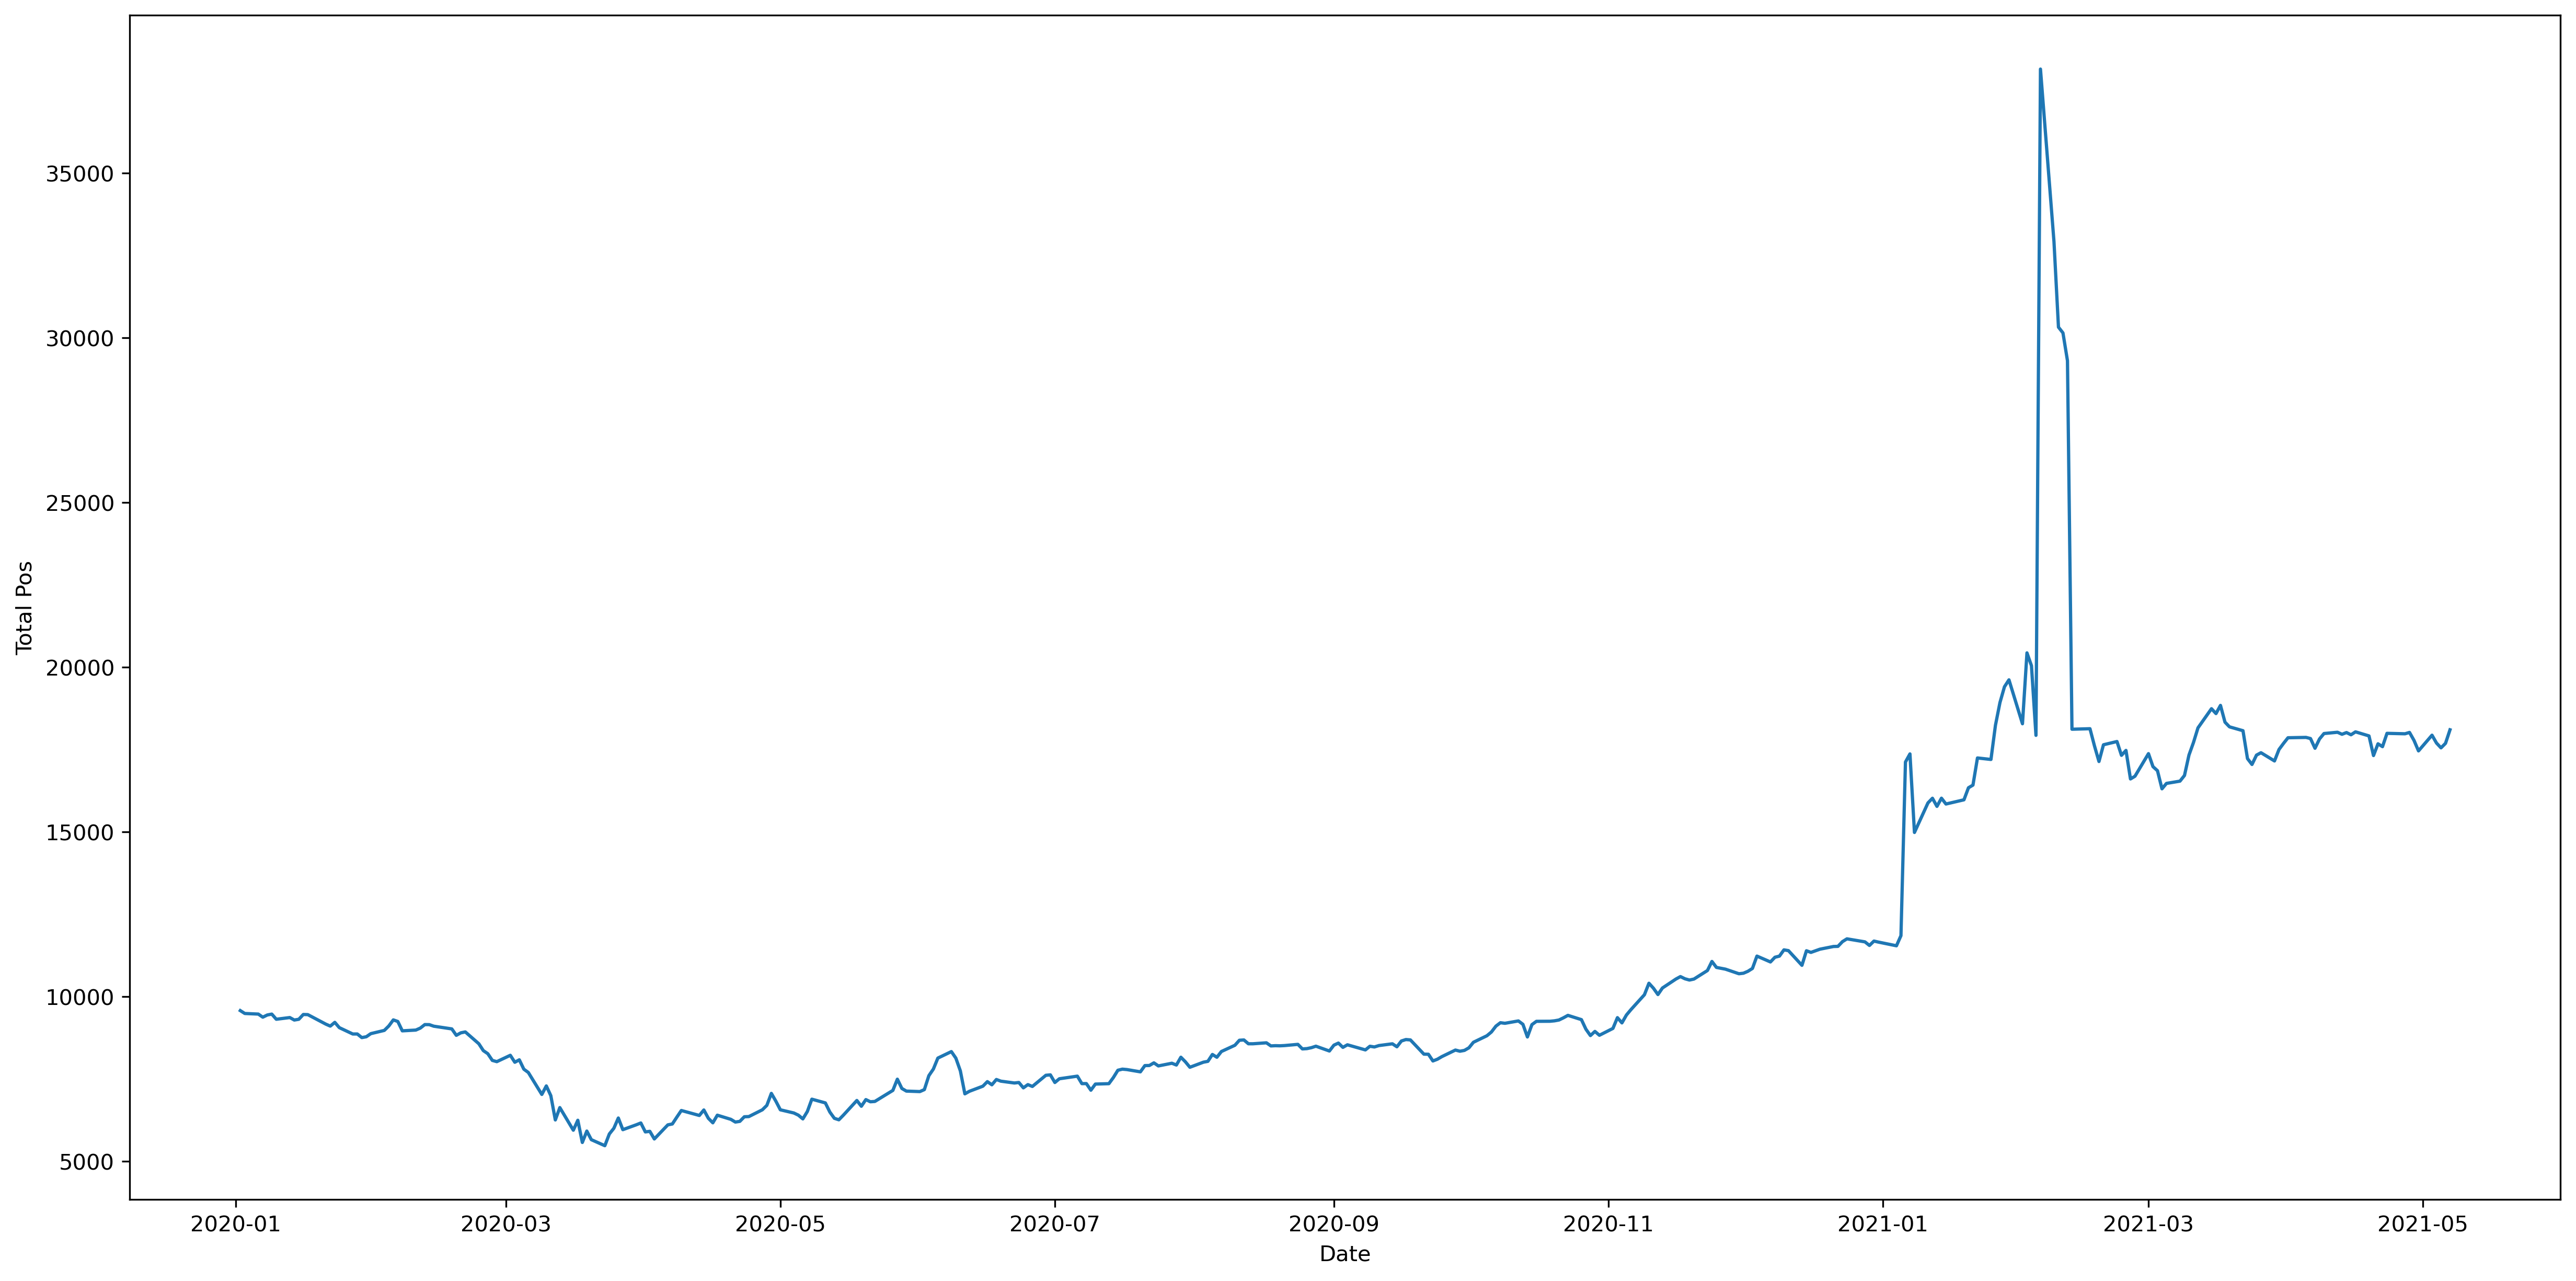

In [85]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(20, 10))
sns.lineplot(data=tkrDf['Total Pos'], palette='bone')
plt.show()

In [122]:
df= pd.DataFrame(farmFrame['DE'])
df['Normalized Returns'] = df/df.iloc[0]
df['Pct Change'] = df['DE'].pct_change()[1:]
ret = df['Pct Change'].sum()
cumret = (ret+1).cumprod()
display(df['Normalized Returns'])



array([1.94516351])

Date
2020-01-02    1.000000
2020-01-03    0.992593
2020-01-06    0.999717
2020-01-07    0.982359
2020-01-08    0.994572
                ...   
2021-05-03    2.154984
2021-05-04    2.188482
2021-05-05    2.184331
2021-05-06    2.248040
2021-05-07    2.272890
Name: Normalized Returns, Length: 340, dtype: float64